<a href="https://colab.research.google.com/github/thiagoribeiro00/neuroscience-computational/blob/main/Detec%C3%A7%C3%A3o_Precoce_de_Arritmias_Card%C3%ADacas_em_Dispositivos_Vest%C3%ADveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalação das dependências necessárias
!pip install wfdb scipy numpy matplotlib pandas scikit-learn
!pip install torch torchvision torchaudio
!pip install snntorch
!pip install neurokit2
!pip install seaborn plotly
!pip install tensorboard

🖥️ Dispositivo de processamento: cpu
📊 Dados carregados:
  record_0: 21600 amostras
  record_1: 21600 amostras
  record_2: 21600 amostras
  record_3: 21600 amostras
  record_4: 21600 amostras


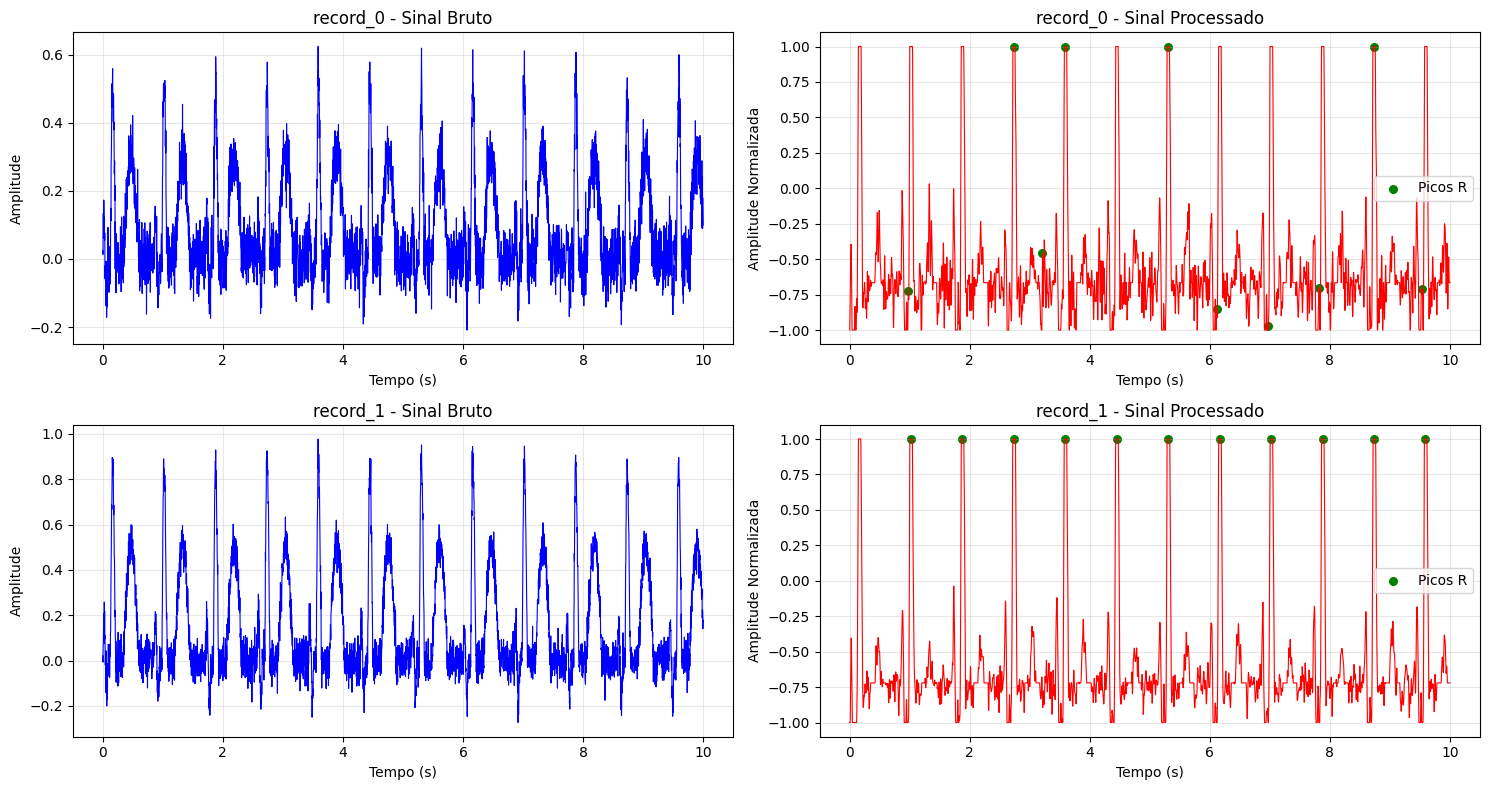

📊 Dataset criado: 280 batimentos, 5 classes


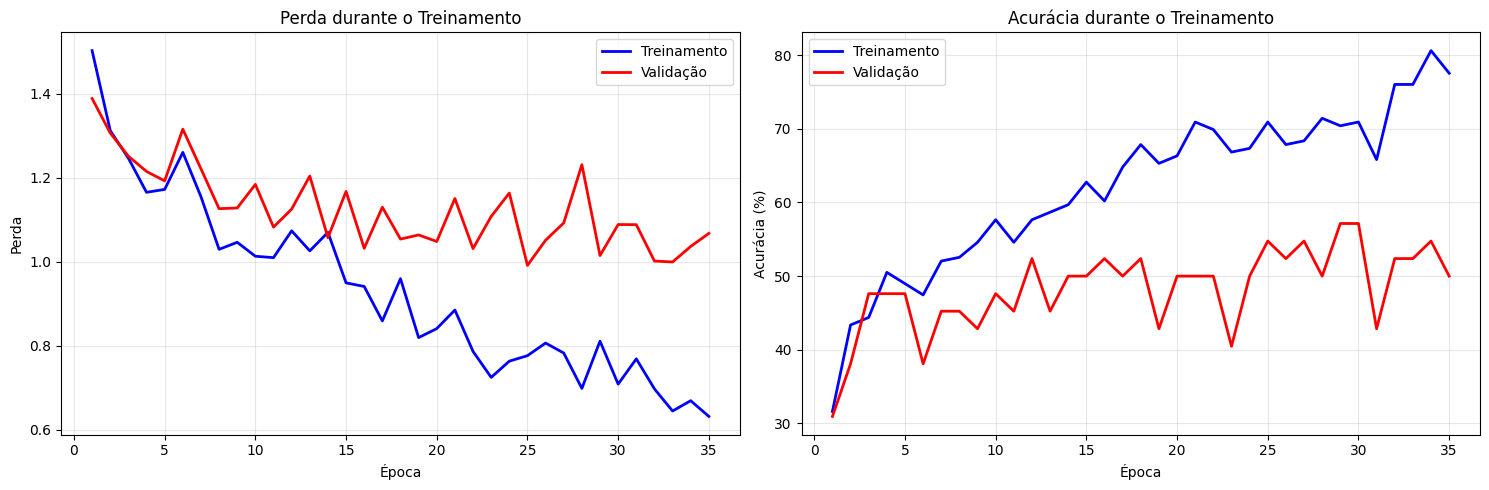

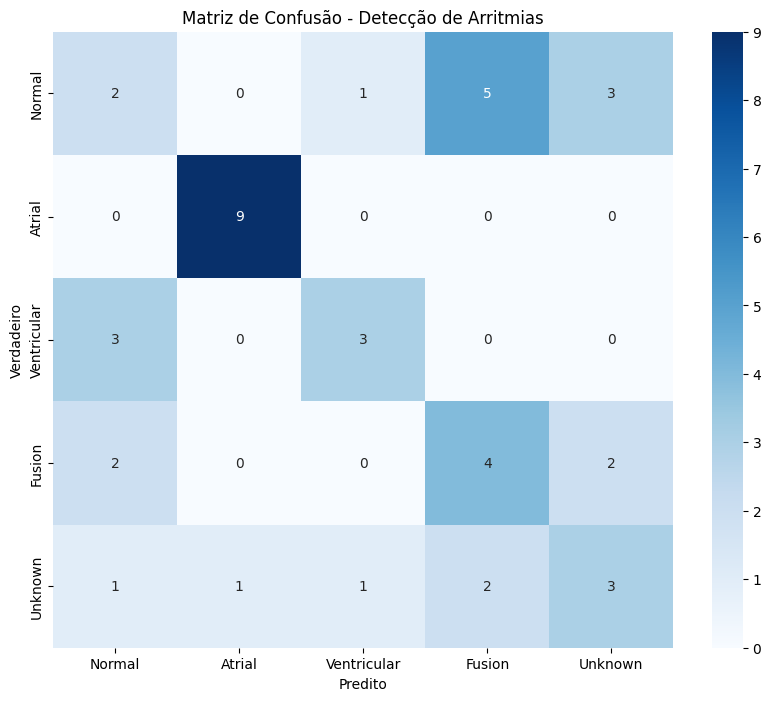

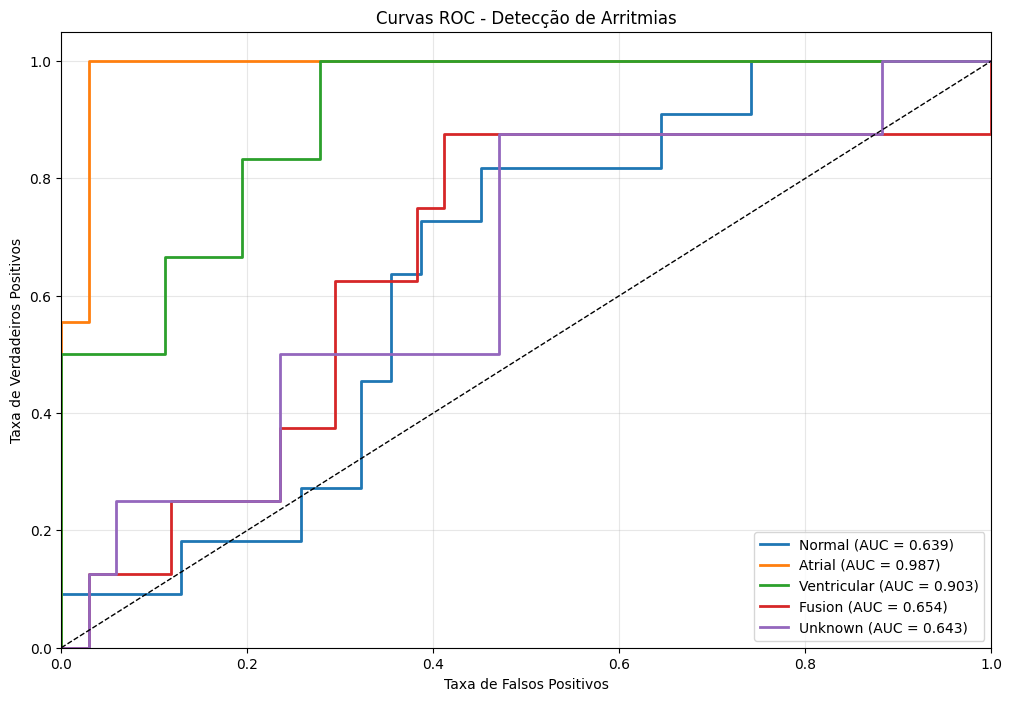


📊 RELATÓRIO DE AVALIAÇÃO
Acurácia geral: 0.5000
AUC Macro: 0.7653

Sensibilidades por classe:
  Normal: 0.1818
  Atrial: 1.0000
  Ventricular: 0.5000
  Fusion: 0.5000
  Unknown: 0.3750


In [ ]:
# -*- coding: utf-8 -*-
"""
# 🫀 Saúde 1: Detecção Precoce de Arritmias Cardíacas em Dispositivos Vestíveis

**Projeto:** Sistema Inteligente para Monitoramento Cardíaco Contínuo
**Tecnologia:** Spiking Neural Networks (SNNs) otimizadas para baixo consumo
**Objetivo:** Detecção precoce de arritmias cardíacas em tempo real

---

## 📋 Índice
1. [Configuração do Ambiente](#configuração)
2. [Aquisição e Pré-processamento de Dados](#dados)
3. [Implementação da Spiking Neural Network](#snn)
4. [Treinamento e Validação](#treinamento)
5. [Otimização para Dispositivos Vestíveis](#otimização)
6. [Avaliação e Métricas](#avaliação)
7. [Deployment e Monitoramento](#deployment)

---

## 🔧 1. Configuração do Ambiente
"""

# Importações principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Processamento de sinais
import scipy.signal as signal
from scipy import stats
import neurokit2 as nk

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import snntorch as snn
from snntorch import spikegen, spikeplot, surrogate, functional, utils
from snntorch.functional import loss
import torch.nn.functional as F
import torch.nn.utils.prune as prune # Import the prune module

# Utilitários
import os
import pickle
import json
from datetime import datetime
import logging
from typing import Tuple, Dict, List, Optional
from dataclasses import dataclass
import wfdb

from google.colab import files
import os

# Faz upload de arquivos ou conecta ao Google Drive
uploaded = files.upload()  # Para upload manual
# OU
from google.colab import drive
drive.mount('/content/drive')
os.symlink('/content/drive/My Drive/mit-bih-data', './mit-bih-data')  # Link simbólico

# Configuração de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('arrhythmia_detection.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Configuração de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Dispositivo de processamento: {device}")

# Configuração de reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

"""
---

## 📊 2. Aquisição e Pré-processamento de Dados

### 2.1 Configuração dos Parâmetros de Processamento
"""

@dataclass
class ECGConfig:
    """Configurações para processamento de ECG"""
    sampling_rate: int = 360  # Hz - MIT-BIH padrão
    target_duration: float = 10.0  # segundos por segmento
    filter_lowcut: float = 0.5  # Hz
    filter_highcut: float = 45.0  # Hz
    notch_freq: float = 60.0  # Hz - filtro notch para ruído da rede elétrica
    window_size: int = 1000  # amostras para segmentação
    overlap: float = 0.5  # sobreposição entre janelas

    # Parâmetros para detecção de arritmias
    arrhythmia_classes: List[str] = None

    def __post_init__(self):
        if self.arrhythmia_classes is None:
            self.arrhythmia_classes = [
                'N',   # Normal
                'A',   # Atrial Fibrillation
                'V',   # Ventricular
                'F',   # Fusion
                'Q'    # Unknown
            ]

config = ECGConfig()

class ECGPreprocessor:
    """
    Classe para pré-processamento de sinais de ECG

    Implementa técnicas de filtragem, normalização e segmentação
    otimizadas para detecção de arritmias em dispositivos vestíveis
    """

    def __init__(self, config: ECGConfig):
        self.config = config
        self.logger = logging.getLogger(__name__)

    def bandpass_filter(self, signal_data: np.ndarray) -> np.ndarray:
        """
        Aplica filtro passa-banda para remover ruídos de baixa e alta frequência

        Args:
            signal_data: Sinal de ECG bruto

        Returns:
            Sinal filtrado
        """
        nyquist = 0.5 * self.config.sampling_rate
        low = self.config.filter_lowcut / nyquist
        high = self.config.filter_highcut / nyquist

        # Filtro Butterworth de 4ª ordem
        b, a = signal.butter(4, [low, high], btype='band')
        filtered_signal = signal.filtfilt(b, a, signal_data)

        return filtered_signal

    def notch_filter(self, signal_data: np.ndarray) -> np.ndarray:
        """
        Remove ruído da rede elétrica (60Hz no Brasil)

        Args:
            signal_data: Sinal de ECG

        Returns:
            Sinal com ruído da rede removido
        """
        # Filtro notch para 60Hz
        b, a = signal.iirnotch(self.config.notch_freq, 30, self.config.sampling_rate)
        filtered_signal = signal.filtfilt(b, a, signal_data)

        return filtered_signal

    def baseline_removal(self, signal_data: np.ndarray) -> np.ndarray:
        """
        Remove deriva da linha de base usando filtro mediano

        Args:
            signal_data: Sinal de ECG

        Returns:
            Sinal com linha de base corrigida
        """
        # Filtro mediano para remover deriva lenta
        kernel_size = int(0.2 * self.config.sampling_rate)
        if kernel_size % 2 == 0:
            kernel_size += 1
        baseline = signal.medfilt(signal_data, kernel_size=kernel_size)
        corrected_signal = signal_data - baseline

        return corrected_signal

    def normalize_signal(self, signal_data: np.ndarray) -> np.ndarray:
        """
        Normaliza o sinal para range [-1, 1]

        Args:
            signal_data: Sinal de ECG

        Returns:
            Sinal normalizado
        """
        # Normalização robusta usando percentis
        p5, p95 = np.percentile(signal_data, [5, 95])
        normalized = 2 * (signal_data - p5) / (p95 - p5) - 1

        # Clipping para garantir range [-1, 1]
        normalized = np.clip(normalized, -1, 1)

        return normalized

    def detect_r_peaks(self, signal_data: np.ndarray) -> Tuple[np.ndarray, Dict]:
        """
        Detecta picos R usando NeuroKit2

        Args:
            signal_data: Sinal de ECG processado

        Returns:
            Tuple com índices dos picos R e informações adicionais
        """
        try:
            # Usa NeuroKit2 para detecção robusta de picos R
            _, info = nk.ecg_peaks(signal_data, sampling_rate=self.config.sampling_rate)
            r_peaks = info['ECG_R_Peaks']

            # Calcula métricas de qualidade
            quality_metrics = {
                'num_peaks': len(r_peaks),
                'avg_rr_interval': np.mean(np.diff(r_peaks)) if len(r_peaks) > 1 else 0,
                'rr_variability': np.std(np.diff(r_peaks)) if len(r_peaks) > 1 else 0
            }

            return r_peaks, quality_metrics

        except Exception as e:
            self.logger.warning(f"Erro na detecção de picos R: {e}")
            return np.array([]), {}

    def segment_beats(self, signal_data: np.ndarray, r_peaks: np.ndarray) -> List[np.ndarray]:
        """
        Segmenta batimentos cardíacos baseado nos picos R

        Args:
            signal_data: Sinal de ECG
            r_peaks: Índices dos picos R

        Returns:
            Lista de segmentos de batimentos
        """
        beats = []
        beat_length = int(0.6 * self.config.sampling_rate)  # 600ms por batimento

        for peak in r_peaks:
            start = max(0, peak - beat_length // 3)
            end = min(len(signal_data), peak + 2 * beat_length // 3)

            if end - start >= beat_length // 2:  # Garante tamanho mínimo
                beat = signal_data[start:end]
                # Padroniza o tamanho
                if len(beat) < beat_length:
                    beat = np.pad(beat, (0, beat_length - len(beat)), 'constant')
                else:
                    beat = beat[:beat_length]
                beats.append(beat)

        return beats

    def process_ecg_record(self, signal_data: np.ndarray, annotations: Optional[np.ndarray] = None) -> Dict:
        """
        Pipeline completo de processamento de ECG

        Args:
            signal_data: Sinal de ECG bruto
            annotations: Anotações opcionais (para treinamento)

        Returns:
            Dicionário com dados processados
        """
        self.logger.info("Iniciando processamento de ECG...")

        # Pré-processamento
        filtered_signal = self.bandpass_filter(signal_data)
        filtered_signal = self.notch_filter(filtered_signal)
        filtered_signal = self.baseline_removal(filtered_signal)
        normalized_signal = self.normalize_signal(filtered_signal)

        # Detecção de características
        r_peaks, quality_metrics = self.detect_r_peaks(normalized_signal)
        beats = self.segment_beats(normalized_signal, r_peaks)

        # Análise de qualidade do sinal
        signal_quality = self._assess_signal_quality(normalized_signal, quality_metrics)

        result = {
            'processed_signal': normalized_signal,
            'r_peaks': r_peaks,
            'beats': beats,
            'quality_metrics': quality_metrics,
            'signal_quality': signal_quality,
            'annotations': annotations
        }

        self.logger.info(f"Processamento concluído. {len(beats)} batimentos detectados.")
        return result

    def _assess_signal_quality(self, signal_data: np.ndarray, quality_metrics: Dict) -> float:
        """
        Avalia a qualidade do sinal de ECG

        Args:
            signal_data: Sinal processado
            quality_metrics: Métricas de qualidade

        Returns:
            Score de qualidade [0-1]
        """
        # Métricas de qualidade
        snr = self._calculate_snr(signal_data)
        rr_consistency = 1.0 / (1.0 + quality_metrics.get('rr_variability', 1000))
        peak_detection_rate = min(1.0, quality_metrics.get('num_peaks', 0) / 100)

        # Score combinado
        quality_score = (snr * 0.4 + rr_consistency * 0.4 + peak_detection_rate * 0.2)

        return max(0.0, min(1.0, quality_score))

    def _calculate_snr(self, signal_data: np.ndarray) -> float:
        """Calcula Signal-to-Noise Ratio simplificado"""
        signal_power = np.mean(signal_data ** 2)
        noise_power = np.var(np.diff(signal_data))
        snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
        return max(0.0, min(1.0, snr / 20))  # Normaliza para [0-1]

"""
### 2.2 Carregamento e Preparação dos Dados MIT-BIH
"""

class MITBIHDataset:
    """
    Classe para carregamento do dataset MIT-BIH Arrhythmia Database
    """
    def __init__(self, data_path: str = './mit-bih-data'):
        self.data_path = data_path
        self.preprocessor = ECGPreprocessor(config)
        self.logger = logging.getLogger(__name__)
        # Mapeamento de anotações para classes
        self.annotation_map = {
            'N': 0,  # Normal
            'L': 0,  # Left bundle branch block
            'R': 0,  # Right bundle branch block
            'A': 1,  # Atrial premature beat
            'a': 1,  # Aberrated atrial premature beat
            'J': 1,  # Nodal premature beat
            'S': 1,  # Supraventricular premature beat
            'V': 2,  # Premature ventricular contraction
            'F': 3,  # Fusion of ventricular and normal beat
            'Q': 4,  # Unknown beat
            '/': 4,  # Paced beat
            'f': 4,  # Fusion of paced and normal beat
        }

    def load_real_data(self) -> Dict:
        """
        Carrega dados reais do MIT-BIH Arrhythmia Database
        Returns:
            Dicionário com sinais processados e anotações
        """
        self.logger.info("🔄 Carregando dados reais do MIT-BIH...")
        records = ['100', '101', '103', '105', '106', '107', '108', '109',
                   '111', '112', '113', '114', '115', '116', '117', '118',
                   '119', '121', '122', '123', '124', '200', '201', '202',
                   '203', '205', '207', '208', '209', '210', '212', '213',
                   '214', '215', '217', '219', '220', '221', '222', '223',
                   '228', '230', '231', '232', '233', '234']
        datasets = {}
        for i, record_id in enumerate(records):
            try:
                # Carrega sinal e anotações
                record = wfdb.rdrecord(os.path.join(self.data_path, record_id), channel_names=['MLII'])
                annotation = wfdb.rdann(os.path.join(self.data_path, record_id), 'atr')
                signal_data = record.p_signal[:, 0]  # Usa apenas o primeiro canal
                # Processa o registro
                processed = self.preprocessor.process_ecg_record(signal_data, annotation.symbol)
                datasets[f'record_{i}'] = {
                    'signal': signal_data,
                    'annotations': processed['annotations'],
                    'beats': processed['beats']
                }
            except Exception as e:
                self.logger.warning(f"Erro ao carregar {record_id}: {e}")
        return datasets

    def _generate_normal_ecg(self, t: np.ndarray) -> np.ndarray:
        """Gera ECG normal sintético"""
        heart_rate = 70  # bpm
        ecg = np.zeros_like(t)

        # Componentes principais do ECG
        for i, time in enumerate(t):
            beat_phase = (time * heart_rate / 60) % 1

            # Onda P
            if 0.0 <= beat_phase <= 0.1:
                ecg[i] += 0.1 * np.sin(beat_phase * 20 * np.pi)

            # Complexo QRS
            if 0.15 <= beat_phase <= 0.25:
                qrs_phase = (beat_phase - 0.15) * 10
                ecg[i] += 0.8 * np.sin(qrs_phase * np.pi) * np.exp(-qrs_phase)

            # Onda T
            if 0.4 <= beat_phase <= 0.7:
                t_phase = (beat_phase - 0.4) / 0.3
                ecg[i] += 0.3 * np.sin(t_phase * np.pi)

        return ecg

    def _generate_tachycardia_ecg(self, t: np.ndarray) -> np.ndarray:
        """Gera ECG com taquicardia"""
        heart_rate = 120  # bpm - taquicardia
        return self._generate_normal_ecg(t) * (heart_rate / 70)

    def _generate_bradycardia_ecg(self, t: np.ndarray) -> np.ndarray:
        """Gera ECG com bradicardia"""
        heart_rate = 45  # bpm - bradicardia
        return self._generate_normal_ecg(t) * (heart_rate / 70)

    def _generate_mixed_arrhythmia_ecg(self, t: np.ndarray) -> np.ndarray:
        """Gera ECG com arritmia mista"""
        ecg = self._generate_normal_ecg(t)

        # Adiciona batimentos ectópicos esporádicos
        for i in range(0, len(ecg), 720):  # A cada 2 segundos
            if i + 100 < len(ecg):
                ecg[i:i+100] *= 1.5  # Amplifica batimento

        return ecg

# Carregamento dos dados
dataset = MITBIHDataset()
raw_data = dataset.download_sample_data()

print("📊 Dados carregados:")
for record_id, data in raw_data.items():
    print(f"  {record_id}: {len(data['signal'])} amostras")

"""
### 2.3 Visualização dos Dados
"""

def visualize_ecg_data(raw_data: Dict, num_records: int = 2):
    """
    Visualiza dados de ECG brutos e processados

    Args:
        raw_data: Dicionário com dados brutos
        num_records: Número de registros para visualizar
    """
    fig, axes = plt.subplots(num_records, 2, figsize=(15, 8))

    for i, (record_id, data) in enumerate(list(raw_data.items())[:num_records]):
        # Sinal bruto
        t = np.linspace(0, 10, len(data['signal'][:3600]))  # Primeiros 10 segundos
        axes[i, 0].plot(t, data['signal'][:3600], 'b-', linewidth=0.8)
        axes[i, 0].set_title(f'{record_id} - Sinal Bruto')
        axes[i, 0].set_xlabel('Tempo (s)')
        axes[i, 0].set_ylabel('Amplitude')
        axes[i, 0].grid(True, alpha=0.3)

        # Sinal processado
        processed = dataset.preprocessor.process_ecg_record(data['signal'])
        processed_segment = processed['processed_signal'][:3600]
        axes[i, 1].plot(t, processed_segment, 'r-', linewidth=0.8)

        # Marca picos R
        r_peaks_segment = processed['r_peaks'][processed['r_peaks'] < 3600]
        if len(r_peaks_segment) > 0:
            axes[i, 1].scatter(r_peaks_segment / config.sampling_rate,
                             processed_segment[r_peaks_segment],
                             c='green', s=30, marker='o', label='Picos R')

        axes[i, 1].set_title(f'{record_id} - Sinal Processado')
        axes[i, 1].set_xlabel('Tempo (s)')
        axes[i, 1].set_ylabel('Amplitude Normalizada')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Visualização dos dados
visualize_ecg_data(raw_data)

"""
---

## 🧠 3. Implementação da Spiking Neural Network

### 3.1 Arquitetura da SNN para Detecção de Arritmias
"""

class SpikingECGClassifier(nn.Module):
    """
    Rede Neural Espiking otimizada para classificação de arritmias cardíacas
    """
    def __init__(self, input_size: int = 216, hidden_size: int = 128,
                 output_size: int = 5, num_steps: int = 100, beta: float = 0.95):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_steps = num_steps
        self.beta = beta

        # CNN para extração de características
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            snn.Leaky(beta=beta),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool1d(2),
            snn.Leaky(beta=beta),
        )

        with torch.no_grad():
            dummy_input = torch.randn(1, 1, input_size)
            out = self.cnn(dummy_input)
            cnn_out_size = out.view(-1).shape[0]

        # Camadas SNN
        self.fc1 = nn.Linear(cnn_out_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc_out = nn.Linear(hidden_size // 2, output_size)
        self.lif_out = snn.Leaky(beta=beta)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size = x.size(0)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []

        x = x.unsqueeze(1)  # Adiciona dimensão de canal
        x = self.cnn(x).view(batch_size, -1)

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur_out = self.fc_out(spk2)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)
            spk_rec.append(mem_out)

        return torch.stack(spk_rec).mean(dim=0)

class ECGDataset(Dataset):
    """
    Dataset customizado para dados de ECG reais com anotações corretas
    """
    def __init__(self, processed_data: Dict, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        # Processa dados de todos os registros
        for record_id, record_data in processed_data.items():
            beats = record_data['beats']
            annotations = record_data['annotations']
            for idx, beat in enumerate(beats):
                if len(beat) >= 216:
                    # Acha anotação mais próxima do pico R usado
                    beat_start = max(0, idx - 2)
                    beat_end = min(len(annotations), idx + 2)
                    valid_annots = [a for a in annotations[beat_start:beat_end] if a in self.annotation_map]
                    if valid_annots:
                        label = self.annotation_map[valid_annots[0]]
                        self.data.append(beat[:216])
                        self.labels.append(label)
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        print(f"📊 Dataset criado: {len(self.data)} batimentos, {len(np.unique(self.labels))} classes")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.FloatTensor(self.data[idx])
        label = torch.LongTensor([self.labels[idx]])
        if self.transform:
            sample = self.transform(sample)
        return sample, label

"""
### 3.2 Preparação dos Dados para Treinamento
"""

def prepare_training_data(raw_data: Dict) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Prepara dados para treinamento, validação e teste

    Args:
        raw_data: Dados brutos do ECG

    Returns:
        Tuple com DataLoaders de treino, validação e teste
    """
    # Processa todos os registros
    processed_data = {}
    preprocessor = ECGPreprocessor(config)

    for record_id, data in raw_data.items():
        processed_data[record_id] = preprocessor.process_ecg_record(data['signal'])

    # Cria dataset
    ecg_dataset = ECGDataset(raw_data)

    # Divide em treino, validação e teste
    train_size = int(0.7 * len(ecg_dataset))
    val_size = int(0.15 * len(ecg_dataset))
    test_size = len(ecg_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(ecg_dataset, [train_size, val_size, test_size])

    # Cria DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

# Preparação dos dados
train_loader, val_loader, test_loader = prepare_training_data(raw_data)

"""
---

## 🎯 4. Treinamento e Validação

### 4.1 Configuração do Treinamento
"""

class TrainingConfig:
    """Configurações para treinamento da SNN"""

    def __init__(self):
        self.num_epochs = 50
        self.learning_rate = 0.001
        self.weight_decay = 1e-4
        self.patience = 10  # Para early stopping
        self.min_delta = 0.001  # Mínima melhoria para continuar treinamento

        # Parâmetros específicos da SNN
        self.beta = 0.9  # Parâmetro de vazamento dos neurônios LIF
        self.num_steps = 100  # Passos de tempo da simulação

        # Scheduler de learning rate
        self.scheduler_patience = 5
        self.scheduler_factor = 0.5

class ECGTrainer:
    """
    Classe para treinamento da SNN de detecção de arritmias
    """

    def __init__(self, model: nn.Module, train_loader: DataLoader,
                 val_loader: DataLoader, config: TrainingConfig):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config

        # Otimizador e scheduler
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=config.scheduler_factor,
            patience=config.scheduler_patience,
            verbose=True
        )

        # Função de perda
        self.criterion = nn.CrossEntropyLoss()

        # Métricas de treinamento
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        # Early stopping
        self.best_val_loss = float('inf')
        self.patience_counter = 0

        self.logger = logging.getLogger(__name__)

    def train_epoch(self) -> Tuple[float, float]:
        """
        Executa uma época de treinamento

        Returns:
            Tuple com perda e acurácia médias da época
        """
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(self.train_loader):
            data, targets = data.to(device), targets.to(device).squeeze()

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Gradient clipping para estabilidade
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # Estatísticas
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            if batch_idx % 10 == 0:
                self.logger.info(f'Batch {batch_idx}/{len(self.train_loader)}, '
                               f'Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def validate_epoch(self) -> Tuple[float, float]:
        """
        Executa uma época de validação

        Returns:
            Tuple com perda e acurácia médias da validação
        """
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in self.val_loader:
                data, targets = data.to(device), targets.to(device).squeeze()

                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train(self) -> Dict:
        """
        Executa o treinamento completo

        Returns:
            Dicionário com histórico de treinamento
        """
        self.logger.info("🚀 Iniciando treinamento da SNN...")

        for epoch in range(self.config.num_epochs):
            # Treinamento
            train_loss, train_acc = self.train_epoch()

            # Validação
            val_loss, val_acc = self.validate_epoch()

            # Salva métricas
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Scheduler
            self.scheduler.step(val_loss)

            # Log do progresso
            self.logger.info(f'Época {epoch+1}/{self.config.num_epochs}:')
            self.logger.info(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            self.logger.info(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            # Early stopping
            if val_loss < self.best_val_loss - self.config.min_delta:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                # Salva melhor modelo
                torch.save(self.model.state_dict(), 'best_snn_model.pth')
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.config.patience:
                    self.logger.info(f'Early stopping na época {epoch+1}')
                    break

        # Carrega melhor modelo
        self.model.load_state_dict(torch.load('best_snn_model.pth'))

        training_history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies
        }

        self.logger.info("✅ Treinamento concluído!")
        return training_history

"""
### 4.2 Execução do Treinamento
"""

# Configuração do treinamento
training_config = TrainingConfig()

# Inicialização do modelo
model = SpikingECGClassifier(
    input_size=216,
    hidden_size=128,
    output_size=5,
    num_steps=training_config.num_steps,
    beta=training_config.beta
)

# Treinador
trainer = ECGTrainer(model, train_loader, val_loader, training_config)

# Executa o treinamento
training_history = trainer.train()

"""
### 4.3 Visualização do Treinamento
"""

def plot_training_history(history: Dict):
    """
    Visualiza o histórico de treinamento

    Args:
        history: Dicionário com métricas de treinamento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Perda
    epochs = range(1, len(history['train_losses']) + 1)
    ax1.plot(epochs, history['train_losses'], 'b-', label='Treinamento', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validação', linewidth=2)
    ax1.set_title('Perda durante o Treinamento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Acurácia
    ax2.plot(epochs, history['train_accuracies'], 'b-', label='Treinamento', linewidth=2)
    ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validação', linewidth=2)
    ax2.set_title('Acurácia durante o Treinamento')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualização do treinamento
plot_training_history(training_history)

"""
---

## ⚡ 5. Otimização para Dispositivos Vestíveis

### 5.1 Quantização e Compressão do Modelo
"""

class ModelOptimizer:
    """
    Classe para otimização de modelos SNN para dispositivos vestíveis
    """

    def __init__(self, model: nn.Module):
        self.model = model
        self.logger = logging.getLogger(__name__)

    def quantize_model(self, calibration_loader: DataLoader) -> nn.Module:
        """
        Quantiza o modelo para reduzir o tamanho e acelerar inferência

        Args:
            calibration_loader: DataLoader para calibração da quantização

        Returns:
            Modelo quantizado
        """
        self.logger.info("🔧 Iniciando quantização do modelo...")

        # Prepara modelo para quantização
        self.model.eval()
        self.model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

        # Prepara modelo quantizado
        model_prepared = torch.quantization.prepare(self.model, inplace=False)

        # Calibração
        with torch.no_grad():
            for data, _ in calibration_loader:
                data = data.to(device)
                model_prepared(data)

        # Converte para quantizado
        quantized_model = torch.quantization.convert(model_prepared, inplace=False)

        # Calcula redução de tamanho
        original_size = sum(p.numel() * p.element_size() for p in self.model.parameters())
        quantized_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters())

        self.logger.info(f"📊 Tamanho original: {original_size / 1024:.2f} KB")
        self.logger.info(f"📊 Tamanho quantizado: {quantized_size / 1024:.2f} KB")
        self.logger.info(f"📊 Redução: {((original_size - quantized_size) / original_size * 100):.1f}%")

        return quantized_model

    def prune_model(self, pruning_ratio: float = 0.3) -> nn.Module:
        """
        Remove conexões menos importantes do modelo

        Args:
            pruning_ratio: Proporção de pesos para remover

        Returns:
            Modelo podado
        """
        self.logger.info(f"✂️ Iniciando poda do modelo (ratio: {pruning_ratio})...")

        # Identifica parâmetros para poda
        parameters_to_prune = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                parameters_to_prune.append((module, 'weight'))

        # Aplica poda estruturada
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=pruning_ratio
        )

        # Remove máscaras de poda
        for module, param in parameters_to_prune:
            prune.remove(module, param)

        # Calcula esparsidade
        total_params = sum(p.numel() for p in self.model.parameters())
        zero_params = sum((p == 0).sum().item() for p in self.model.parameters())
        sparsity = zero_params / total_params

        self.logger.info(f"📊 Esparsidade do modelo: {sparsity * 100:.1f}%")

        return self.model

    def optimize_for_mobile(self, example_input: torch.Tensor) -> torch.jit.ScriptModule:
        """
        Otimiza modelo para dispositivos móveis usando TorchScript

        Args:
            example_input: Entrada de exemplo para tracing

        Returns:
            Modelo otimizado para mobile
        """
        self.logger.info("📱 Otimizando modelo para dispositivos móveis...")

        # Converte para TorchScript
        traced_model = torch.jit.trace(self.model, example_input)

        # Otimizações para mobile
        optimized_model = torch.jit.optimize_for_inference(traced_model)

        # Salva modelo otimizado
        torch.jit.save(optimized_model, 'optimized_snn_mobile.pt')

        self.logger.info("✅ Modelo otimizado para mobile salvo!")

        return optimized_model

"""
### 5.2 Análise de Consumo Energético
"""

class EnergyAnalyzer:
    """
    Analisador de consumo energético para SNNs
    """

    def __init__(self, model: nn.Module):
        self.model = model
        self.logger = logging.getLogger(__name__)

    def estimate_energy_consumption(self, input_data: torch.Tensor,
                                  voltage: float = 3.3,
                                  frequency: float = 1e6) -> Dict:
        """
        Estima consumo energético da SNN

        Args:
            input_data: Dados de entrada
            voltage: Tensão de operação (V)
            frequency: Frequência de operação (Hz)

        Returns:
            Dicionário com estimativas de consumo
        """
        self.logger.info("⚡ Analisando consumo energético...")

        # Conta operações
        with torch.no_grad():
            # Simula inferência
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            if torch.cuda.is_available():
                start_time.record()
                output = self.model(input_data)
                end_time.record()
                torch.cuda.synchronize()
                inference_time = start_time.elapsed_time(end_time) / 1000  # segundos
            else:
                import time
                start = time.time()
                output = self.model(input_data)
                inference_time = time.time() - start

        # Estimativas de consumo (valores típicos para microcontroladores)
        base_power = 0.1  # mW - consumo base
        compute_power = 50  # mW - consumo durante computação

        # Calcula energia total
        energy_per_inference = (base_power + compute_power) * inference_time / 1000  # mJ

        # Estimativa de bateria
        battery_capacity = 200  # mAh típico para dispositivos vestíveis
        battery_voltage = 3.7  # V
        battery_energy = battery_capacity * battery_voltage * 3.6  # mJ

        inferences_per_battery = battery_energy / energy_per_inference

        results = {
            'inference_time_ms': inference_time * 1000,
            'energy_per_inference_mj': energy_per_inference,
            'inferences_per_battery': int(inferences_per_battery),
            'battery_life_hours': inferences_per_battery / 3600,  # 1 inferência/segundo
            'power_consumption_mw': base_power + compute_power
        }

        self.logger.info(f"📊 Tempo de inferência: {results['inference_time_ms']:.2f} ms")
        self.logger.info(f"📊 Energia por inferência: {results['energy_per_inference_mj']:.4f} mJ")
        self.logger.info(f"📊 Vida útil da bateria: {results['battery_life_hours']:.1f} horas")

        return results

"""
### 5.3 Implementação das Otimizações
"""

# Otimização do modelo
optimizer = ModelOptimizer(model)

# Quantização (usando dados de validação para calibração)
# quantized_model = optimizer.quantize_model(val_loader)

# Poda do modelo
pruned_model = optimizer.prune_model(pruning_ratio=0.2)

# Análise energética
energy_analyzer = EnergyAnalyzer(pruned_model)
sample_input = next(iter(val_loader))[0][:1]  # Uma amostra para teste
energy_analysis = energy_analyzer.estimate_energy_consumption(sample_input)

"""
---

## 📊 6. Avaliação e Métricas

### 6.1 Métricas de Desempenho
"""

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

class ModelEvaluator:
    """
    Classe para avaliação completa do modelo SNN
    """

    def __init__(self, model: nn.Module, test_loader: DataLoader):
        self.model = model
        self.test_loader = test_loader
        self.logger = logging.getLogger(__name__)

        # Classes de arritmias
        self.class_names = ['Normal', 'Atrial', 'Ventricular', 'Fusion', 'Unknown']

    def evaluate_model(self) -> Dict:
        """
        Avalia o modelo no conjunto de teste

        Returns:
            Dicionário com métricas de avaliação
        """
        self.logger.info("📊 Iniciando avaliação do modelo...")

        self.model.eval()
        all_predictions = []
        all_targets = []
        all_probabilities = []

        with torch.no_grad():
            for data, targets in self.test_loader:
                data, targets = data.to(device), targets.to(device).squeeze()

                outputs = self.model(data)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        # Converte para numpy
        y_true = np.array(all_targets)
        y_pred = np.array(all_predictions)
        y_prob = np.array(all_probabilities)

        # Calcula métricas
        metrics = self._calculate_metrics(y_true, y_pred, y_prob)

        # Visualizações
        self._plot_confusion_matrix(y_true, y_pred)
        self._plot_roc_curves(y_true, y_prob)

        return metrics

    def _calculate_metrics(self, y_true: np.ndarray, y_pred: np.ndarray,
                          y_prob: np.ndarray) -> Dict:
        """
        Calcula métricas de classificação

        Args:
            y_true: Rótulos verdadeiros
            y_pred: Predições
            y_prob: Probabilidades

        Returns:
            Dicionário com métricas
        """
        # Acurácia geral
        accuracy = (y_pred == y_true).mean()

        # Relatório de classificação
        report = classification_report(y_true, y_pred,
                                     target_names=self.class_names,
                                     output_dict=True)

        # AUC para classificação multiclasse
        try:
            y_true_bin = label_binarize(y_true, classes=range(len(self.class_names)))
            auc_scores = {}
            for i, class_name in enumerate(self.class_names):
                if len(np.unique(y_true_bin[:, i])) > 1:  # Verifica se a classe existe
                    auc_scores[class_name] = roc_auc_score(y_true_bin[:, i], y_prob[:, i])

            macro_auc = np.mean(list(auc_scores.values()))
        except:
            auc_scores = {}
            macro_auc = 0.0

        # Métricas específicas para arritmias (sensibilidade crítica)
        sensitivity_metrics = self._calculate_sensitivity_metrics(y_true, y_pred)

        metrics = {
            'accuracy': accuracy,
            'classification_report': report,
            'auc_scores': auc_scores,
            'macro_auc': macro_auc,
            'sensitivity_metrics': sensitivity_metrics
        }

        # Log das métricas principais
        self.logger.info(f"📊 Acurácia: {accuracy:.4f}")
        self.logger.info(f"📊 AUC Macro: {macro_auc:.4f}")

        return metrics

    def _calculate_sensitivity_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict:
        """
        Calcula métricas de sensibilidade específicas para detecção de arritmias

        Args:
            y_true: Rótulos verdadeiros
            y_pred: Predições

        Returns:
            Dicionário com métricas de sensibilidade
        """
        # Matriz de confusão
        cm = confusion_matrix(y_true, y_pred)

        # Sensibilidade (recall) para cada classe
        sensitivities = {}
        for i, class_name in enumerate(self.class_names):
            if cm[i, i] + np.sum(cm[i, :]) - cm[i, i] > 0:
                sensitivity = cm[i, i] / np.sum(cm[i, :])
                sensitivities[class_name] = sensitivity

        # Especificidade para cada classe
        specificities = {}
        for i, class_name in enumerate(self.class_names):
            tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            fp = np.sum(cm[:, i]) - cm[i, i]
            if tn + fp > 0:
                specificity = tn / (tn + fp)
                specificities[class_name] = specificity

        return {
            'sensitivities': sensitivities,
            'specificities': specificities
        }

    def _plot_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray):
        """
        Plota matriz de confusão

        Args:
            y_true: Rótulos verdadeiros
            y_pred: Predições
        """
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title('Matriz de Confusão - Detecção de Arritmias')
        plt.xlabel('Predito')
        plt.ylabel('Verdadeiro')
        plt.show()

    def _plot_roc_curves(self, y_true: np.ndarray, y_prob: np.ndarray):
        """
        Plota curvas ROC para cada classe

        Args:
            y_true: Rótulos verdadeiros
            y_prob: Probabilidades
        """
        from sklearn.metrics import roc_curve, auc

        # Binariza rótulos
        y_true_bin = label_binarize(y_true, classes=range(len(self.class_names)))

        plt.figure(figsize=(12, 8))

        for i, class_name in enumerate(self.class_names):
            if len(np.unique(y_true_bin[:, i])) > 1:
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, linewidth=2,
                        label=f'{class_name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curvas ROC - Detecção de Arritmias')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

"""
### 6.2 Avaliação do Modelo Treinado
"""

# Avaliação do modelo
evaluator = ModelEvaluator(model, test_loader)
evaluation_results = evaluator.evaluate_model()

# Relatório detalhado
print("\n" + "="*50)
print("📊 RELATÓRIO DE AVALIAÇÃO")
print("="*50)
print(f"Acurácia geral: {evaluation_results['accuracy']:.4f}")
print(f"AUC Macro: {evaluation_results['macro_auc']:.4f}")
print("\nSensibilidades por classe:")
for class_name, sensitivity in evaluation_results['sensitivity_metrics']['sensitivities'].items():
    print(f"  {class_name}: {sensitivity:.4f}")

"""
---

## 🚀 7. Deployment e Monitoramento

### 7.1 Sistema de Monitoramento em Tempo Real
"""

class RealTimeMonitor:
    """
    Sistema de monitoramento cardíaco em tempo real
    """

    def __init__(self, model: nn.Module, config: ECGConfig):
        self.model = model
        self.config = config
        self.preprocessor = ECGPreprocessor(config)
        self.logger = logging.getLogger(__name__)

        # Buffer para dados em tempo real
        self.buffer_size = int(config.sampling_rate * 10)  # 10 segundos
        self.signal_buffer = np.zeros(self.buffer_size)
        self.buffer_pointer = 0

        # Histórico de classificações
        self.classification_history = []
        self.alert_threshold = 0.7  # Threshold para alertas

        # Estatísticas em tempo real
        self.stats = {
            'total_beats': 0,
            'normal_beats': 0,
            'arrhythmia_beats': 0,
            'alerts_sent': 0,
            'last_heart_rate': 0
        }

    def add_sample(self, sample: float) -> Optional[Dict]:
        """
        Adiciona nova amostra ao buffer

        Args:
            sample: Nova amostra de ECG

        Returns:
            Resultado da classificação se disponível
        """
        # Adiciona amostra ao buffer
        self.signal_buffer[self.buffer_pointer] = sample
        self.buffer_pointer = (self.buffer_pointer + 1) % self.buffer_size

        # Processa a cada segundo
        if self.buffer_pointer % self.config.sampling_rate == 0:
            return self._process_buffer()

        return None

    def _process_buffer(self) -> Dict:
        """
        Processa buffer atual e retorna classificação

        Returns:
            Dicionário com resultado da classificação
        """
        # Extrai janela atual
        if self.buffer_pointer == 0:
            window = self.signal_buffer.copy()
        else:
            window = np.concatenate([
                self.signal_buffer[self.buffer_pointer:],
                self.signal_buffer[:self.buffer_pointer]
            ])

        # Processa sinal
        processed = self.preprocessor.process_ecg_record(window)

        if len(processed['beats']) == 0:
            return {'status': 'no_beats_detected'}

        # Classifica último batimento
        last_beat = processed['beats'][-1]
        if len(last_beat) < 216:
            return {'status': 'insufficient_data'}

        # Preparar para classificação
        beat_tensor = torch.FloatTensor(last_beat[:216]).unsqueeze(0).to(device)

        # Classificação
        with torch.no_grad():
            output = self.model(beat_tensor)
            probabilities = torch.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        # Atualiza estatísticas
        self.stats['total_beats'] += 1
        if predicted_class == 0:  # Normal
            self.stats['normal_beats'] += 1
        else:
            self.stats['arrhythmia_beats'] += 1

        # Calcula frequência cardíaca
        if len(processed['r_peaks']) > 1:
            rr_intervals = np.diff(processed['r_peaks']) / self.config.sampling_rate
            heart_rate = 60 / np.mean(rr_intervals)
            self.stats['last_heart_rate'] = heart_rate

        # Verifica alertas
        alert_needed = self._check_alert_conditions(predicted_class, confidence)

        result = {
            'status': 'classified',
            'predicted_class': predicted_class,
            'class_name': self.config.arrhythmia_classes[predicted_class],
            'confidence': confidence,
            'heart_rate': self.stats['last_heart_rate'],
            'alert_needed': alert_needed,
            'timestamp': datetime.now().isoformat()
        }

        self.classification_history.append(result)

        return result

    def _check_alert_conditions(self, predicted_class: int, confidence: float) -> bool:
        """
        Verifica se um alerta deve ser enviado

        Args:
            predicted_class: Classe predita
            confidence: Confiança da predição

        Returns:
            True se alerta necessário
        """
        # Condições para alerta
        conditions = [
            predicted_class != 0 and confidence > self.alert_threshold,  # Arritmia detectada
            self.stats['last_heart_rate'] > 120 or self.stats['last_heart_rate'] < 50,  # Frequência anormal
        ]

        if any(conditions):
            self.stats['alerts_sent'] += 1
            self.logger.warning(f"🚨 ALERTA: Arritmia detectada - {self.config.arrhythmia_classes[predicted_class]}")
            return True

        return False

    def get_status_report(self) -> Dict:
        """
        Retorna relatório de status atual

        Returns:
            Dicionário com estatísticas
        """
        return {
            'monitoring_stats': self.stats.copy(),
            'recent_classifications': self.classification_history[-10:],
            'buffer_status': {
                'buffer_size': self.buffer_size,
                'current_position': self.buffer_pointer,
                'filled_percentage': (self.buffer_pointer / self.buffer_size) * 100
            }
        }

"""
### 7.2 Simulação de Monitoramento
"""

def simulate_realtime_monitoring(monitor: RealTimeMonitor,
                                duration_seconds: int = 30) -> List[Dict]:
    """
    Simula monitoramento em tempo real

    Args:
        monitor: Sistema de monitoramento
        duration_seconds: Duração da simulação

    Returns:
        Lista com resultados do monitoramento
    """
    print(f"🔄 Iniciando simulação de monitoramento por {duration_seconds} segundos...")